# Fast Neural Style Transfer

In [1]:
import time 

import matplotlib.pyplot as plt
import numpy as np
import torch
# For getting VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image, ImageFile
from tqdm import tqdm_notebook

from fast_neural_style.transformer_net import TransformerNet
from fast_neural_style.utils import (
    gram_matrix, recover_image, tensor_normalizer
)
from fast_neural_style.loss_network import LossNetwork

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
SEED = 1081
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    kwargs = {}

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
DATASET = "../coco_2017/"
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE), 
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(), tensor_normalizer()])
# http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
train_dataset = datasets.ImageFolder(DATASET, transform)
# http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    loss_network = LossNetwork()
    loss_network.to(device)
loss_network.eval()

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReL

In [5]:
loss_network

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReL

In [6]:
STYLE_IMAGE = "../style_images/mosaic.jpg"
style_img = Image.open(STYLE_IMAGE).convert('RGB')
with torch.no_grad():
    style_img_tensor = transforms.Compose([
        # transforms.Resize(IMAGE_SIZE* 2),
        transforms.ToTensor(),
        tensor_normalizer()]
    )(style_img).unsqueeze(0)
    # assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
    style_img_tensor = style_img_tensor.to(device)

Sanity check:

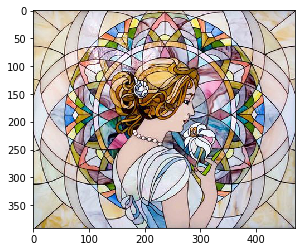

In [7]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

Precalculate gram matrices of the style image:

In [8]:
# http://pytorch.org/docs/master/notes/autograd.html#volatile
with torch.no_grad():
    style_loss_features = loss_network(style_img_tensor)
    gram_style = [gram_matrix(y) for y in style_loss_features]

In [9]:
style_loss_features._fields

('relu1', 'relu2', 'relu3', 'relu4', 'relu5')

In [10]:
for i in range(len(style_loss_features)):
    tmp = style_loss_features[i].cpu().numpy()
    print(i, np.mean(tmp), np.std(tmp))

0 0.8696425 2.0772192
1 1.3954027 3.5784333
2 1.7436607 6.0051637
3 0.40489754 1.6580398
4 0.08247852 0.4453365


In [11]:
for i in range(len(style_loss_features)):
    print(i, gram_style[i].numel(), gram_style[i].size())

0 4096 torch.Size([1, 64, 64])
1 16384 torch.Size([1, 128, 128])
2 65536 torch.Size([1, 256, 256])
3 262144 torch.Size([1, 512, 512])
4 262144 torch.Size([1, 512, 512])


## Train the Transformer / Image Generator
Utility function to save debug images during training:

In [12]:
def save_debug_image(tensor_orig, tensor_transformed, tensor_with_noise, filename):
    assert tensor_orig.size() == tensor_transformed.size()
    result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
    noise = Image.fromarray(recover_image(tensor_with_noise.cpu().numpy())[0])
    orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
    new_im = Image.new('RGB', (result.size[0] * 3 + 10, result.size[1]))
    new_im.paste(orig, (0,0))
    new_im.paste(result, (result.size[0] + 5,0))
    new_im.paste(noise, (result.size[0] * 2 + 10,0))
    new_im.save(filename)

In [13]:
%mkdir -p ../debug

In [14]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
# l1_loss = torch.nn.L1Loss()
transformer.to(device)

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

In [15]:
torch.set_default_tensor_type('torch.FloatTensor')
   
def train(steps, base_steps=0):
    transformer.train()
    count = 0
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.   
    agg_stable_loss = 0.
    while True:
        for x, _ in train_loader:
            count += 1
            optimizer.zero_grad()
            x = x.to(device)             
            y = transformer(x)            
            with torch.no_grad():                      
                mask = torch.bernoulli(torch.ones_like(
                    x, device=device, dtype=torch.float
                ) * NOISE_P)
                noise = torch.normal(
                    torch.zeros_like(x), 
                    torch.ones_like(
                        x, device=device, dtype=torch.float
                    ) * NOISE_STD
                ).clamp(-1, 1)
                # print((noise * mask).sum())
            y_noise = transformer(x + noise * mask)
                        
            with torch.no_grad():
                xc = x.detach()
                features_xc = loss_network(xc)
            
            features_y = loss_network(y)
            
            with torch.no_grad():
                f_xc_c = features_xc[2].detach()

            content_loss = CONTENT_WEIGHT * mse_loss(features_y[2], f_xc_c)

            reg_loss = REGULARIZATION * (
                torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            style_loss = 0.
            for l, weight in enumerate(STYLE_WEIGHTS):
                gram_s = gram_style[l]
                gram_y = gram_matrix(features_y[l])
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))
                
            stability_loss = NOISE_WEIGHT * mse_loss(y_noise.view(-1), y.view(-1).detach())

            total_loss = content_loss + style_loss + reg_loss + stability_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss
            agg_style_loss += style_loss
            agg_reg_loss += reg_loss
            agg_stable_loss += stability_loss

            if count % LOG_INTERVAL == 0:
                mesg = "{} [{}/{}] content: {:.2f}  style: {:.2f}  reg: {:.2f} stable: {:.2f} total: {:.6f}".format(
                            time.ctime(), count, steps,
                            agg_content_loss / LOG_INTERVAL,
                            agg_style_loss / LOG_INTERVAL,
                            agg_reg_loss / LOG_INTERVAL,
                            agg_stable_loss / LOG_INTERVAL,
                            (agg_content_loss + agg_style_loss + 
                             agg_reg_loss + agg_stable_loss) / LOG_INTERVAL
                        )
                print(mesg)
                agg_content_loss = 0.
                agg_style_loss = 0.
                agg_reg_loss = 0.
                agg_stable_loss = 0.
                transformer.eval()
                y = transformer(x)
                save_debug_image(x, y.detach(), y_noise.detach(), "../debug/{}.png".format(base_steps + count))
                transformer.train()
                
            if count >= steps:
                return

In [16]:
len(train_loader)

10168

In [17]:
CONTENT_WEIGHT = 1
STYLE_WEIGHTS = np.array([1e-1, 1, 1e1, 5, 1e1]) * 5e3
REGULARIZATION = 1e-6
NOISE_P = 0.2
NOISE_STD = 0.35
NOISE_WEIGHT = 10 * 2
LOG_INTERVAL = 50

LR = 1e-3
optimizer = Adam(transformer.parameters(), LR)

In [18]:
train(1000, 0)

Fri Jun 22 08:59:25 2018 [50/1000] content: 23.31  style: 22.68  reg: 0.15 stable: 0.12 total: 46.257732
Fri Jun 22 09:00:10 2018 [100/1000] content: 23.92  style: 13.19  reg: 0.22 stable: 0.27 total: 37.598778
Fri Jun 22 09:00:54 2018 [150/1000] content: 23.53  style: 11.49  reg: 0.24 stable: 0.28 total: 35.541225
Fri Jun 22 09:01:38 2018 [200/1000] content: 22.49  style: 11.05  reg: 0.24 stable: 0.31 total: 34.095135
Fri Jun 22 09:02:23 2018 [250/1000] content: 21.48  style: 10.83  reg: 0.25 stable: 0.28 total: 32.846127
Fri Jun 22 09:03:07 2018 [300/1000] content: 20.78  style: 10.59  reg: 0.26 stable: 0.35 total: 31.974953
Fri Jun 22 09:03:51 2018 [350/1000] content: 19.86  style: 10.24  reg: 0.26 stable: 0.36 total: 30.733110
Fri Jun 22 09:04:36 2018 [400/1000] content: 19.49  style: 9.96  reg: 0.27 stable: 0.32 total: 30.044664
Fri Jun 22 09:05:20 2018 [450/1000] content: 18.72  style: 9.99  reg: 0.27 stable: 0.35 total: 29.324808
Fri Jun 22 09:06:04 2018 [500/1000] content: 18.4

In [19]:
optimizer = Adam(transformer.parameters(), LR * 0.5)

In [20]:
train(3000, 1000)

Fri Jun 22 09:14:12 2018 [50/3000] content: 16.28  style: 10.00  reg: 0.26 stable: 0.50 total: 27.036842
Fri Jun 22 09:14:57 2018 [100/3000] content: 15.64  style: 9.69  reg: 0.26 stable: 0.51 total: 26.111582
Fri Jun 22 09:15:41 2018 [150/3000] content: 15.59  style: 9.42  reg: 0.27 stable: 0.44 total: 25.718576
Fri Jun 22 09:16:25 2018 [200/3000] content: 15.48  style: 9.75  reg: 0.27 stable: 0.49 total: 25.990177
Fri Jun 22 09:17:10 2018 [250/3000] content: 15.25  style: 9.48  reg: 0.27 stable: 0.48 total: 25.476418
Fri Jun 22 09:17:54 2018 [300/3000] content: 15.16  style: 9.53  reg: 0.27 stable: 0.48 total: 25.441628
Fri Jun 22 09:18:39 2018 [350/3000] content: 15.36  style: 9.55  reg: 0.27 stable: 0.48 total: 25.665602
Fri Jun 22 09:19:23 2018 [400/3000] content: 15.17  style: 9.47  reg: 0.27 stable: 0.49 total: 25.403034
Fri Jun 22 09:20:08 2018 [450/3000] content: 15.02  style: 9.43  reg: 0.27 stable: 0.49 total: 25.211966
Fri Jun 22 09:20:53 2018 [500/3000] content: 15.07  sty

In [21]:
save_model_path = "../models/mosaic_4000_vgg19.pth"
torch.save(transformer.state_dict(), save_model_path)

In [22]:
optimizer = Adam(transformer.parameters(), LR * 0.1)

In [23]:
LOG_INTERVAL = 100
train(6000, 4000)

Fri Jun 22 09:59:40 2018 [100/6000] content: 13.40  style: 9.14  reg: 0.28 stable: 0.58 total: 23.394016
Fri Jun 22 10:01:09 2018 [200/6000] content: 13.24  style: 9.08  reg: 0.28 stable: 0.56 total: 23.163996
Fri Jun 22 10:02:38 2018 [300/6000] content: 13.21  style: 9.20  reg: 0.27 stable: 0.57 total: 23.255476
Fri Jun 22 10:04:06 2018 [400/6000] content: 13.18  style: 9.13  reg: 0.28 stable: 0.53 total: 23.120558
Fri Jun 22 10:05:35 2018 [500/6000] content: 13.30  style: 9.17  reg: 0.28 stable: 0.57 total: 23.311518
Fri Jun 22 10:07:03 2018 [600/6000] content: 13.14  style: 9.07  reg: 0.28 stable: 0.59 total: 23.076822
Fri Jun 22 10:08:32 2018 [700/6000] content: 13.23  style: 9.12  reg: 0.28 stable: 0.55 total: 23.184605
Fri Jun 22 10:10:00 2018 [800/6000] content: 13.03  style: 8.93  reg: 0.28 stable: 0.54 total: 22.783020
Fri Jun 22 10:11:29 2018 [900/6000] content: 13.10  style: 9.13  reg: 0.28 stable: 0.55 total: 23.045511
Fri Jun 22 10:12:57 2018 [1000/6000] content: 13.10  st

In [24]:
save_model_path = "../models/mosaic_10000_vgg19.pth"
torch.save(transformer.state_dict(), save_model_path)

In [25]:
import glob
fnames = glob.glob(DATASET + r"/*/*")
len(fnames)

40670

In [26]:
transformer = transformer.eval()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


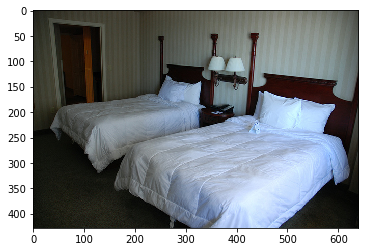

In [47]:
img = Image.open(fnames[70]).convert('RGB')
transform = transforms.Compose([
                                
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

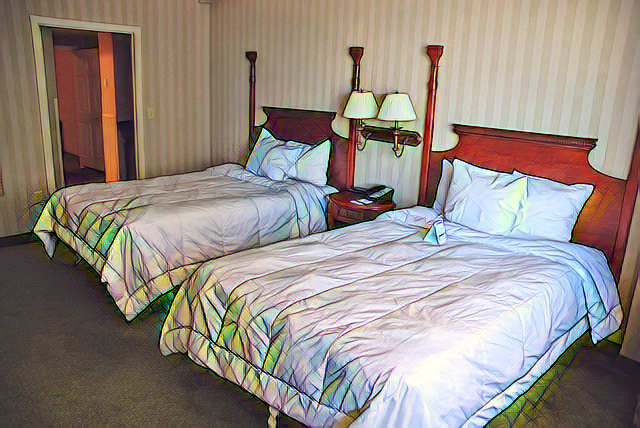

In [48]:
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


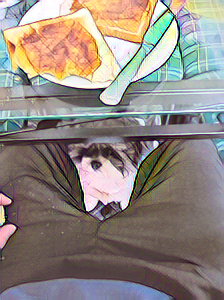

In [51]:
transform = transforms.Compose([
                                transforms.Resize(IMAGE_SIZE),
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

torch.Size([1, 3, 512, 512])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


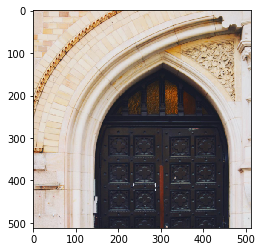

In [31]:
img = Image.open("../content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

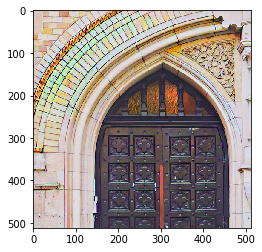

In [32]:
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

torch.Size([1, 3, 224, 224])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


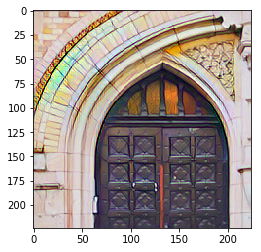

In [33]:
img = Image.open("../content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

In [34]:
output_img = Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])
output_img.save("amber.png")